In [3]:
%env HF_HOME=/scratch/zara/.cache/huggingface

import tqdm
import torch
import datetime
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from dialz import Dataset, SteeringModel, SteeringVector
from utils import bbq_axes, load_and_tokenize_contrastive, contrastive_pairs
from transformers import AutoTokenizer

env: HF_HOME=/scratch/zara/.cache/huggingface


In [4]:
def batched_get_hiddens(
    model,
    tokenizer,
    inputs: list[str],
    hidden_layers: list[int],
    batch_size: int,
    pooling: str = 'final'  # 'final' or 'mean'
) -> dict[int, np.ndarray]:
    """
    Extract hidden states for each example and layer, with optional pooling.

    Args:
        model: a HuggingFace model with output_hidden_states=True
        tokenizer: corresponding tokenizer
        inputs: list of input strings
        hidden_layers: indices of layers to extract (0-based)
        batch_size: inference batch size
        pooling: 'final' to take last non-pad token; 'mean' to average all tokens

    Returns:
        dict mapping layer -> array of shape (len(inputs), hidden_dim)
    """
    batched_inputs = [inputs[i:i + batch_size] for i in range(0, len(inputs), batch_size)]
    hidden_states = {layer: [] for layer in hidden_layers}

    with torch.no_grad():
        for batch in tqdm.tqdm(batched_inputs, desc="Getting hiddens"):
            encoded = tokenizer(batch, padding=True, return_tensors="pt").to(model.device)
            out = model(**encoded, output_hidden_states=True)
            mask = encoded['attention_mask']  # shape (B, seq_len)

            for i in range(len(batch)):
                for layer in hidden_layers:
                    hidden_idx = layer + 1 if layer >= 0 else layer
                    states = out.hidden_states[hidden_idx][i]  # (seq_len, D)
                    if pooling == 'final':
                        last_idx = mask[i].nonzero(as_tuple=True)[0][-1].item()
                        vec = states[last_idx].cpu().float().numpy()
                    else:  # mean pooling
                        m = mask[i].unsqueeze(-1).float()  # (seq_len, 1)
                        summed = (states * m).sum(dim=0)
                        denom = m.sum()
                        vec = (summed / denom).cpu().float().numpy()
                    hidden_states[layer].append(vec)
            del out

    return {k: np.vstack(v) for k, v in hidden_states.items()}


def visualize_2d_PCA(
    inputs,
    model,
    tokenizer,
    pooling: str = 'final',  # 'final' or 'mean'
    n_cols: int = 5,
    batch_size: int = 32
):
    """
    Perform 2D PCA on the hidden states of positive vs negative examples for each layer,
    plot all layers in a grid, and compute linear separability using a logistic classifier.
    Pooling can be 'final' or 'mean'.
    """
    # Prepare layers and strings
    hidden_layers = list(range(1, model.config.num_hidden_layers))
    train_strs = [s for ex in inputs.entries for s in (ex.positive, ex.negative)]

    # Extract hidden states
    layer_hiddens = batched_get_hiddens(
        model, tokenizer, train_strs, hidden_layers, batch_size, pooling=pooling
    )

    # Setup subplot grid
    n_layers = len(hidden_layers)
    n_rows = math.ceil(n_layers / n_cols)
    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(n_cols * 3, n_rows * 3),
        sharex=False, sharey=False
    )
    axes = axes.flatten()

    scores = []

    # Loop over layers
    for idx, layer in enumerate(tqdm.tqdm(hidden_layers, desc="PCA & Classify")):
        ax = axes[idx]
        h_states = layer_hiddens[layer]    # shape (2N, D)
        # diffs for PCA axis
        diffs = h_states[::2] - h_states[1::2]  # shape (N, D)

        # 2-component PCA fitted on diffs
        pca2 = PCA(n_components=2, whiten=False).fit(diffs)
        proj_all = pca2.transform(h_states)      # project all 2N on PC1/PC2

        # scatter positives vs negatives
        colors = ['blue' if i % 2 == 0 else 'orange' for i in range(proj_all.shape[0])]
        ax.scatter(proj_all[:,0], proj_all[:,1], c=colors, s=8, alpha=0.6)
        ax.axhline(0, color='gray', lw=0.8)
        ax.axvline(0, color='gray', lw=0.8)

        # Compute linear separability on full hidden states
        labels = [1 if i % 2 == 0 else 0 for i in range(h_states.shape[0])]
        clf = LogisticRegression(max_iter=500)
        # cross-validate accuracy

        try:
            sep = cross_val_score(LogisticRegression(max_iter=500), proj_all, labels, cv=5).mean()
        except:
            sep = clf.score(proj_all, labels)
        scores.append({'layer': layer, 'sep_score': sep})


        # Annotate with separability
        ax.set_title(f"L{layer}, Acc={sep:.2f}", fontsize=8)
        ax.set_xticks([])
        ax.set_yticks([])

    # Turn off unused axes
    for j in range(n_layers, len(axes)):
        axes[j].axis('off')

    fig.tight_layout()
    df_scores = pd.DataFrame(scores)

    return fig, df_scores


In [ ]:
model_name = "meta-llama/Llama-3.1-8B-Instruct"
#model_name = "meta-llama/Llama-2-7b-chat"
model = SteeringModel(model_name, [5]) # Second element is arbritary as we're not generating yet


tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token_id = tokenizer.eos_token_id

## Feed in model tokenizer and inputs from each contrastive dataset in python file 3
for axis in bbq_axes:

    print(f"Creating vector for {axis} at:", datetime.datetime.now())

    path  = f"../data/bbq_train/{axis}_train.json"
    train_dataset = load_and_tokenize_contrastive(model_name, path)
    fig, scores = visualize_2d_PCA(train_dataset, model, tokenizer)
    scores.to_csv(f"../data/layer_scores/{axis}_train.csv", index=False)
    fig.savefig(f"../figs/{axis}_bbq_train.png")

    train_dataset = load_and_tokenize_contrastive(model_name, path, prompt=f"Consider the bias related to {axis} in the following. ")
    fig, scores = visualize_2d_PCA(train_dataset, model, tokenizer)
    scores.to_csv(f"../data/layer_scores/{axis}_train+prompt.csv", index=False)
    fig.savefig(f"../figs/{axis}_bbq_train.png")


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Creating vector for age at: 2025-07-17 10:31:24.246197


Getting hiddens:  32%|███▏      | 6/19 [00:04<00:09,  1.33it/s]


KeyboardInterrupt: 

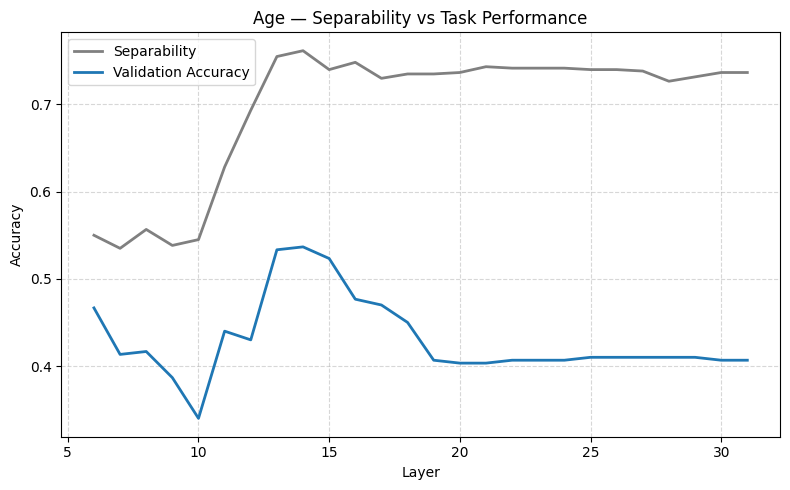

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

bbq_axes     = ["age"]
vector_types = ["train+prompt"]

for axis in bbq_axes:
        for vt in vector_types:
                sep_df = pd.read_csv(f"../data/separability_scores/mistral/{axis}_{vt}.csv")
                acc_df = pd.read_csv(f"../data/layer_scores/mistral/{axis}_{vt}.csv")

                fig, ax = plt.subplots(figsize=(8,5))
                ax.plot(sep_df["layer"][5:], sep_df["sep_score"][5:],
                                label="Separability",
                                color="gray", linewidth=2)
                ax.plot(acc_df["layer"][5:], acc_df["bbq_accuracy"][5:],
                                label="Validation Accuracy",
                                linewidth=2)

                ax.set_xlabel("Layer")
                ax.set_ylabel("Accuracy")
                ax.set_title(f"{axis.capitalize()} — Separability vs Task Performance")
                ax.legend(loc="best")
                ax.grid(True, linestyle="--", alpha=0.5)

                plt.tight_layout()
                fig.savefig(f"../figs/{axis}_{vt}.pdf")
                plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

bbq_axes     = ["age","appearance","disability","gender","nationality","race","religion","socioeconomic"]
vector_types = ["train","train+prompt","generate_qa","generate_ss"]

results = []

for axis in bbq_axes:
    sep_df = pd.read_csv(f"../data/separability_scores/mistral/{axis}_{vt}.csv")
    max_acc = 0
    for vt in vector_types:
        acc_df = pd.read_csv(f"../data/layer_scores/mistral/{axis}_{vt}.csv")
        #acc_df = acc_df[acc_df['layer'] > 5]
        if acc_df['bbq_accuracy'].max() > max_acc:
            vt2 = vt
            max_acc = acc_df['bbq_accuracy'].max()
            max_layer = acc_df.loc[acc_df['bbq_accuracy'].idxmax(), 'layer']
        else:
            continue
    results.append({
        'axis': axis,
        'vt': vt2,
        'max_acc': round(max_acc,3),
        'max_layer': max_layer
    })
    print(axis)
    print(f"{vt2}: highest bbq_accuracy of {max_acc:.2f} at layer {max_layer}")

results_df = pd.DataFrame(results)

results_df.head()
results_df.to_csv('../data/layer_scores/mistral/best_layers/top_layer_?.csv')

age
generate_ss: highest bbq_accuracy of 0.54 at layer 3
appearance
generate_ss: highest bbq_accuracy of 0.60 at layer 6
disability
generate_ss: highest bbq_accuracy of 0.56 at layer 4
gender
generate_ss: highest bbq_accuracy of 0.48 at layer 6
nationality
generate_ss: highest bbq_accuracy of 0.51 at layer 9
race
generate_ss: highest bbq_accuracy of 0.51 at layer 6
religion
generate_ss: highest bbq_accuracy of 0.63 at layer 7
socioeconomic
generate_ss: highest bbq_accuracy of 0.65 at layer 4
